In [26]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def MF_SGD(data):
    item_features, user_features, rmse = matrix_factorization_SGD(data, 0.008, 0.01, 0.01, 20, 30)
    sparse_matrix = user_features.dot(item_features.T)
    return sparse_matrix

def compute_error_alternative(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        item_info = item_features[col]
        user_info = user_features[row]
        mse += (data[row, col] - user_info.T.dot(item_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

def parser(path_csv) :
    maxUserId = 0
    maxMovieId = 0
    with open(path_csv, 'r') as csvfile:
        linereader = csv.reader(csvfile, delimiter = ',')
        next(linereader)
        
        for row in linereader:
            rx, cy = row[0].split('_')
            x, y = int(rx[1:]), int(cy[1:])
            maxUserId = max(maxUserId, x)
            maxMovieId = max(maxMovieId, y)
    sparse_matrix = np.zeros((maxUserId,maxMovieId))
    with open(path_csv, 'r') as csvfile:
        linereader = csv.reader(csvfile, delimiter = ',')
        next(linereader)
        for row in linereader:
            rx, cy = row[0].split('_')
            x, y = int(rx[1:]), int(cy[1:])
            sparse_matrix[x-1][y-1] = int(row[1])
    return sparse_matrix

def matrix_factorization_SGD(train, gamma, lambda_user, lambda_item, num_features, num_epochs):
    """matrix factorization by SGD."""
    errors = [0]
    
    # seed
    np.random.seed(988)  
    
    # init matrices
    num_users, num_items = train.shape 
    user_features = np.random.rand(num_users, num_features)
    item_features = np.random.rand(num_items, num_features)
    
    # non-zero ratings indices 
    nz_row, nz_col = np.nonzero(train)
    nz_train = list(zip(nz_row, nz_col))
    print("Learning matrix factorization...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)

        # decrease step size
        gamma /= 1.2
        
        for x, y in nz_train:
            item_info = item_features[y]
            user_info = user_features[x]

            # compute error : correct value - prediction
            err = train[x, y] - user_info.dot(item_info.T)

            # update latent factors
            item_features[y] += gamma * (err * user_info - lambda_item * item_info)
            user_features[x] += gamma * (err * item_info - lambda_user * user_info)

        rmse = compute_error_alternative(train, user_features, item_features, nz_train)
        print("iteration: {}, RMSE on training set: {}.".format(it, rmse))
        errors.append(rmse)

    return item_features, user_features, errors

In [27]:
### path to the data
path = "../data/"
file_to_read = "data_train.csv"
fileread = path + file_to_read
fileread
train = parser(fileread)
i, u, err = matrix_factorization_SGD(train, 0.008, 0.01, 0.01, 20, 30)

Learning matrix factorization...
iteration: 0, RMSE on training set: 1.005979852470761.
iteration: 1, RMSE on training set: 0.99562723154779.
iteration: 2, RMSE on training set: 0.992188669307008.
iteration: 3, RMSE on training set: 0.9896146826360068.
iteration: 4, RMSE on training set: 0.9883877212533049.
iteration: 5, RMSE on training set: 0.9868366331631652.
iteration: 6, RMSE on training set: 0.9857337677964106.
iteration: 7, RMSE on training set: 0.9847811306346373.
iteration: 8, RMSE on training set: 0.9845721637083699.
iteration: 9, RMSE on training set: 0.9837766810777655.
iteration: 10, RMSE on training set: 0.9835880587912433.
iteration: 11, RMSE on training set: 0.9829525727532762.
iteration: 12, RMSE on training set: 0.9827335842837153.
iteration: 13, RMSE on training set: 0.9824424619496241.
iteration: 14, RMSE on training set: 0.9823578247036814.
iteration: 15, RMSE on training set: 0.9821556064608257.
iteration: 16, RMSE on training set: 0.9820439144588622.
iteration: 1

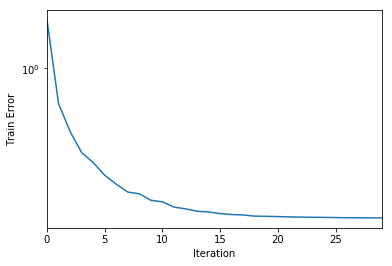

In [25]:
%matplotlib inline
pd.Series(err[1:]).plot(logy=True)
plt.xlabel("Iteration")
plt.ylabel("Train Error")

## Matrix Factorization implemented with Surprise
We used this to find the best parameters, since this library has a method cross-validate.

In [28]:
import surprise

class MF_SGD(surprise.AlgoBase):
    '''Prediction algorithm based on matrix factorization using SGD'''
    
    def __init__(self, gamma, num_features, lambda_user, lambda_item, num_epochs):
        # initialize parameters
        self.gamma = gamma
        self.num_features = num_features
        self.lambda_user = lambda_user
        self.lambda_item = lambda_item
        self.num_epochs = num_epochs

        
    def fit(self, trainset):
        '''learn the vectors user_features and item_features with SGD'''
    
        print('Fitting data with SGD...')
        
        # randomly initialize the user and item factors.
        user_features = np.random.normal(0, .1, (trainset.n_users, self.num_features))
        item_features = np.random.normal(0, .1, (trainset.n_items, self.num_features))
        
        # SGD procedure
        for _ in range(self.num_epochs):
            for u, i, r_ui in trainset.all_ratings():
                user_info = user_features[u]
                item_info = item_features[i]
                err = r_ui - np.dot(user_features[u], item_features[i])
                # update vectors
                user_features[u] += self.gamma * (err * item_info - self.lambda_user * user_info)
                item_features[i] += self.gamma * (err * user_info - self.lambda_item * item_info)
        
        self.user_features, self.item_features = user_features, item_features
        self.trainset = trainset

    def estimate(self, u, i):
        '''return the estimated rating of user u for item i.'''
        # return scalar product between the vectors if user and item are known,
        # else return the average of all ratings
        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            return np.dot(self.user_features[u], self.item_features[i])
        else:
            return self.trainset.global_mean

def rmse_to_csv(rmse, params, name):
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Rmse','Parameters']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(rmse, params):
            writer.writerow({'Rmse':r1, 'Parameters':r2})

In [ ]:
write_new_csv("../data/data_train.csv")
reader = surprise.Reader(line_format="user item rating", sep=',', rating_scale=(1, 5))
data = surprise.Dataset.load_from_file('new_data.csv', reader=reader)
rmses = []
params = []       
#try for some combination of parameters
for gamma in [0.004, 0.006, 0.008, 0.1]:
    for lu in [0.01, 0.03, 0.05, 0.07]:
        for li in [0.01, 0.03, 0.05, 0.07]:
            params.append((gamma, lu, li))           
for (g, lu, li) in params:
    algo = MF_SGD(gamma=g, num_features=20, lambda_user=lu, lambda_item=li, num_epochs=10)
    rmse = surprise.model_selection.cross_validate(algo, data, measures=['RMSE'])
    rmses.append(rmse)
rmse_to_csv(rmses, params, "error_sur1.csv")
print("fin")